Today, twitter is a social media platform that is important for not just sharing media, but sharing news and announcing disasters, accidents, and other important information to the public. This machine learning exercise is important, as it is important to widdle down the incorrect tweets to the actual emergencies with a 'news' source from the public.

This project uses Natural Language Processing (NLP). NLP is a branch of AI focused on enabling computers to understand, interpret, and generate human language. It involves tasks like text tokenization, part-of-speech tagging, and sentiment analysis, with applications spanning from chatbots and language translation to sentiment analysis and information retrieval.

Import libraries we will use

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mount drive to bring in the files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the data from the drive.

In [ ]:
raw_train = pd.read_csv("drive/MyDrive/ML Files/train.csv")
raw_test = pd.read_csv("drive/MyDrive/ML Files/test.csv")
raw_sample = pd.read_csv("drive/MyDrive/ML Files/sample_submission.csv")

In [ ]:
train = raw_train.copy()
test = raw_test.copy()
sample = raw_sample.copy()

Look at sample data, shape, summary, and information about each datapoint.

In [ ]:
print(train.head())
print(train.shape)
print(train.describe())
print(train.info())
print(test.head())
print(test.shape)
print(test.describe())
print(test.info())



   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
(7613, 5)
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------

Remove unneccesary datapoints.

In [ ]:
train = train.drop(columns=['keyword','location'])
test = test.drop(columns=['keyword','location'])

Create a function to clean the text to be able to tokenize.

In [44]:
stop_words = set(stopwords.words('english'))

def clean(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


Cleaning the text to get rid of punctuation, urls, extra space, and making all letters lowercase.

In [ ]:
train['text'] = train['text'].apply(clean)
test['text'] = test['text'].apply(clean)

Graphing the quantity of natural disasters yes (1) and no (0). There is a relatively even number of positive and negative markers.

target
0    4342
1    3271
Name: count, dtype: int64


([<matplotlib.axis.XTick at 0x7a5d58d163b0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

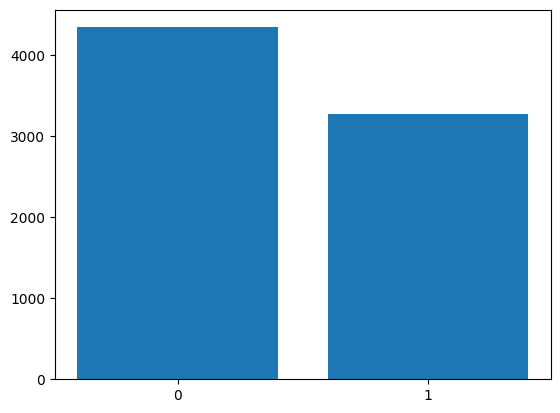

In [ ]:
value_counts = train['target'].value_counts()
print(value_counts)
plt.bar(value_counts.index, value_counts.values)
plt.xticks([0, 1])

Creating a word cloud based on the cleaned training data.

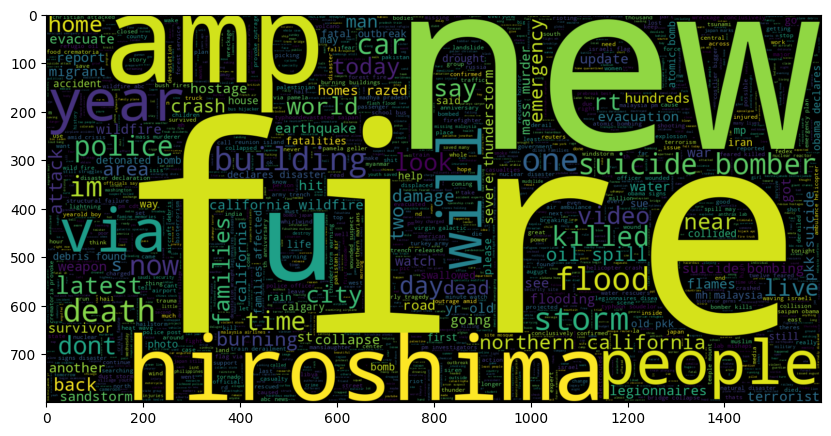

In [45]:
plt.figure(figsize = (10, 10))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(train[train.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train['text'], train['target'], test_size=0.15, random_state=0)

Separated the train data into validation and train data, which allows better training of the model, and preventing overfitting. Then the text is tokenized

In [ ]:
max_length = max([len(x) for x in X_train])
print(max_length)

tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=max_length, padding='post', truncating='post')

142


Preparing the model to be fit to the data.

In [ ]:
embedding_dim = 32
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(1000, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),

    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 50786 (198.38 KB)
Trainable params: 50786 (198.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Fitting the model, with early stopping to prevent overfitting, and validation data to prevent overfitting.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

num_epochs = 10
batch_size = 256

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/10
24/24 - 14s - loss: 0.6818 - accuracy: 0.5652 - val_loss: 0.6670 - val_accuracy: 0.5817 - 14s/epoch - 591ms/step
Epoch 2/10
24/24 - 8s - loss: 0.6333 - accuracy: 0.6379 - val_loss: 0.6443 - val_accuracy: 0.6454 - 8s/epoch - 336ms/step
Epoch 3/10
24/24 - 5s - loss: 0.5245 - accuracy: 0.7714 - val_loss: 0.4767 - val_accuracy: 0.7866 - 5s/epoch - 225ms/step
Epoch 4/10
24/24 - 7s - loss: 0.4268 - accuracy: 0.8072 - val_loss: 0.4762 - val_accuracy: 0.7951 - 7s/epoch - 290ms/step
Epoch 5/10
24/24 - 7s - loss: 0.3979 - accuracy: 0.8268 - val_loss: 0.4616 - val_accuracy: 0.7886 - 7s/epoch - 273ms/step
Epoch 6/10
24/24 - 6s - loss: 0.3815 - accuracy: 0.8355 - val_loss: 0.4717 - val_accuracy: 0.7807 - 6s/epoch - 234ms/step
Epoch 7/10
24/24 - 8s - loss: 0.3678 - accuracy: 0.8381 - val_loss: 0.4791 - val_accuracy: 0.7761 - 8s/epoch - 345ms/step
Epoch 8/10
24/24 - 6s - loss: 0.3569 - accuracy: 0.8468 - val_loss: 0.4742 - val_accuracy: 0.7886 - 6s/epoch - 235ms/step


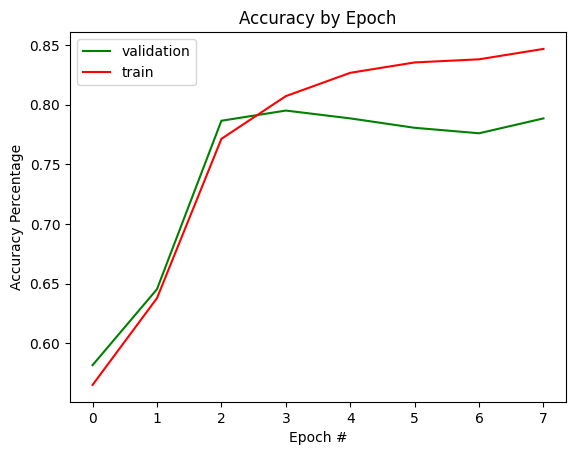

In [46]:
plt.plot(history.history['val_accuracy'], color = 'green')
plt.plot(history.history['accuracy'], color = 'red')
plt.plot()
plt.title('Accuracy by Epoch')
plt.legend(['validation', 'train'])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy Percentage')
plt.show()

Created a Confusion Matrix to display the type 1 and type 2 errors of the data.

48/48 [==============================] - 3s 58ms/step


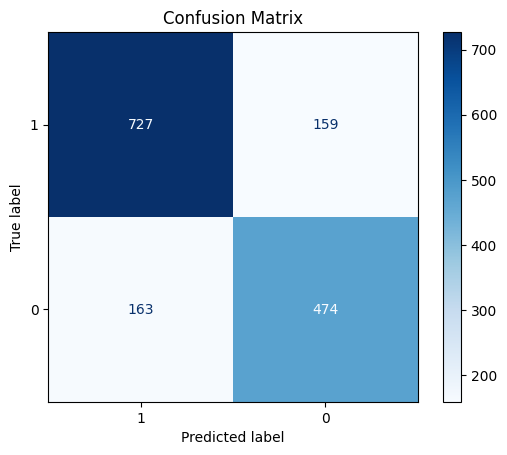

In [47]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_val, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=train['target'].unique().tolist()).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Predicting based on the test data, and exporting as a CSV to submit.

In [49]:
x_test = test['text'].values
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=max_length)
pred = model.predict(x_test)
pred=[np.argmax(x) for x in pred]

102/102 [==============================] - 5s 46ms/step


In [50]:
test['target'] = pred
test[['id','target']].to_csv('submission.csv',index=False)


In [51]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In all this project was a great introduction to NLP. It is something that is very fascinating to try to perfect the text cleaning and preprocessing, and adding and updating this dataset in order to see if it is something worth doing.

The next level of analysis would be analyzing multiple texts occuring at the same time. If 5 people were to tweet about a shooting, this could add to the weight of a disaster happening. This would enable first responders to help actual situations, and not responding to false alarms if that was to be the use of this.

To improve my model, I played with the number of epochs, patience, and number of words. The fewer 'important' words limits the different disasters, but increases the importance of the words that actually matter to determine that it is a disaster. The accuracy of the submission was 0.57.